# ARIMA Time Series Analysis of Bitcoin Stok Prices

## 1. Introduction 

This notebook performs a time series analysis on the historical price data of Bitcoin (BTC-USD). The dataset contains daily information on the opening price, highest price, lowest price, closing price, and trading volume. Such data is well-suited for financial modeling tasks, including forecasting future prices and studying market volatility.

In this notebook, we will:

Explore and visualize the data to understand underlying trends and seasonality.

Perform stationarity tests and transformations to prepare the data for modeling.

Build an ARIMA (AutoRegressive Integrated Moving Average) model to forecast future Bitcoin prices.

Evaluate the model performance and visualize predictions.

This analysis aims to demonstrate how ARIMA can be applied to cryptocurrency time series data, providing insights into potential future price movements based on historical patterns.

## 2. Data Exploration 

Let's take a look inside the data

In [1]:
import pandas as pd

data = pd.read_csv('BTC-USD_stock_data.csv')

data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-01,963.658020,1003.080017,958.698975,998.325012,998.325012,147775008
1,2017-01-02,998.617004,1031.390015,996.702026,1021.750000,1021.750000,222184992
2,2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,1043.839966,185168000
3,2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,1154.729980,344945984
4,2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,1013.380005,510199008


So we have:

The date in YYYY-MM-DD format (Date)
Opening Price for the day (Open)
High Price for the day (High)
Low Price for the day (Low)
Closing Price for the day (Close)
Adjusting Closing Price for the day (Adj Close)
Total # of Bitcoin Traded in the day (Volume)

We are now going to reset the index with the date as a datetime object

In [2]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date').reset_index(drop=True)
data.set_index('Date', inplace=True)

Let's look at the closing price and volume over time with the date adjusted.  We are going to mark surge events in the graph with a function that will label them with numbers.  The events will then be explained in the following box.

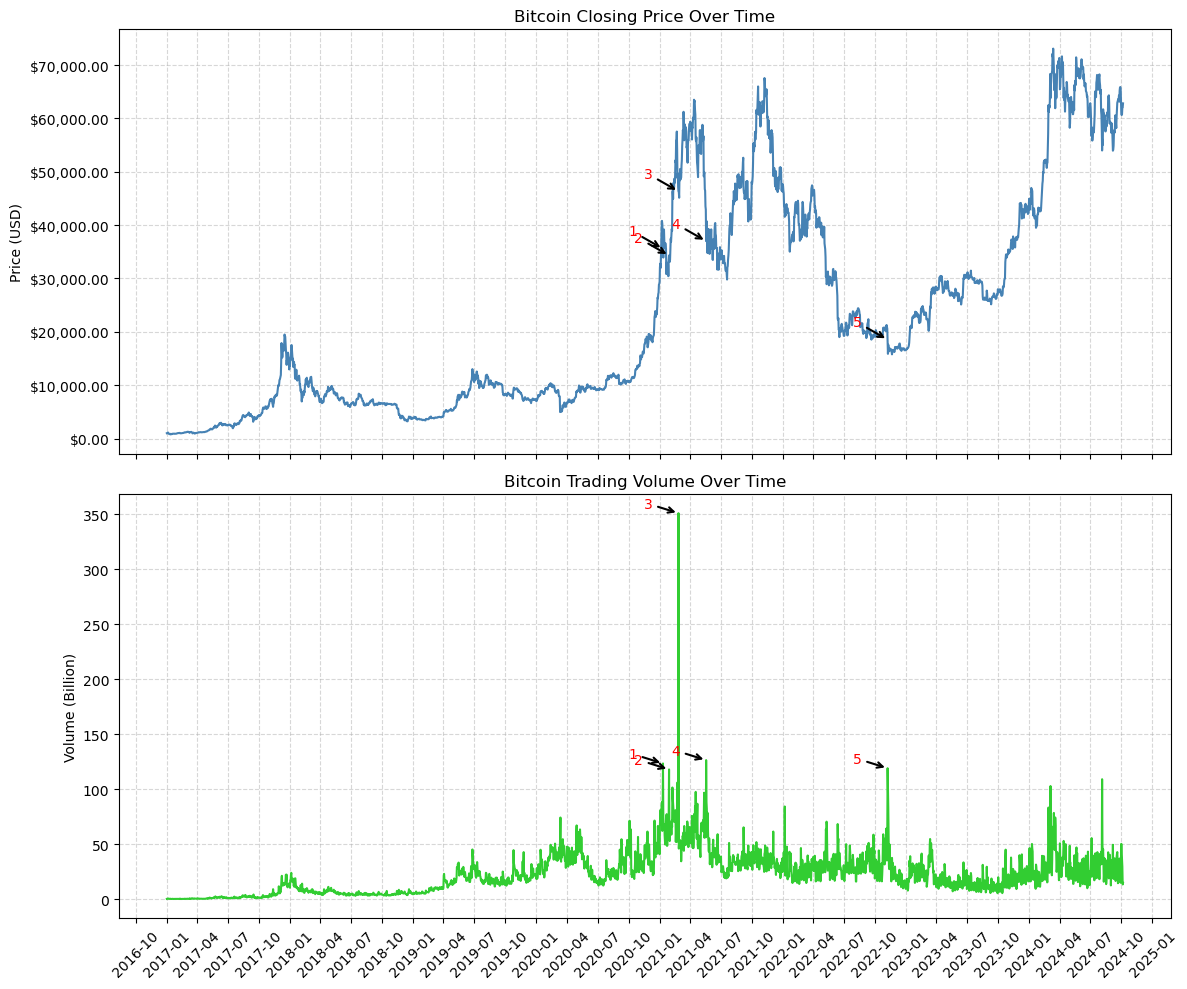

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import numpy as np

def annotate_volume_spikes(ax1, ax2, df, n):

    # rank top
    top_dates = df['Volume'].nlargest(n).index
    top_dates_sorted = sorted(top_dates)

    # annotate both graphs
    for i, date in enumerate(top_dates_sorted, start=1):
        price = df.loc[date, 'Close']
        volume_billion = df.loc[date, 'Volume'] / 1e9

        # annotate top graph (closing price)
        ax1.annotate(f'{i}',
                     xy=(date, price),
                     xytext=(date - pd.Timedelta(days=90), price + 2500),
                     ha='center',
                     color='red',
                     fontsize=10,
                     arrowprops=dict(facecolor='red', arrowstyle='->', lw=1.5))

        # annotate bottom graph (volume)
        ax2.annotate(f'{i}',
                     xy=(date, volume_billion),
                     xytext=(date - pd.Timedelta(days=90), volume_billion + 5),
                     ha='center',
                     color='red',
                     fontsize=10,
                     arrowprops=dict(facecolor='red', arrowstyle='->', lw=1.5))
    
    return top_dates_sorted
        
# plotting function
def plot_price_and_volume(df):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,10), sharex=True)

    # closing subplot
    ax1.plot(df.index, df['Close'], label='Close Price', color='steelblue')
    ax1.set_title('Bitcoin Closing Price Over Time')
    ax1.set_ylabel('Price (USD)')
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x:,.2f}'))
    ax1.grid(True, which='major', linestyle='--', alpha=0.5)

    # volume subplot
    ax2.plot(df.index, df['Volume'] / 1e9, label='Volume (Billions)', color='limegreen')
    ax2.set_title('Bitcoin Trading Volume Over Time')
    ax2.set_ylabel('Volume (Billion)')
    ax2.grid(True, which='major', linestyle='--', alpha=0.5)
    
    # x-axis format
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    
    # annotate top volume spikes
    top_dates = annotate_volume_spikes(ax1, ax2, df, 5)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_price_and_volume(data)

We see some spikes in the volume data, which we can attribute to:

1. **Dec 2020 - Jan 2021**  
   Bitcoin breaks its previous all-time high from 2017 (~$20,000) and surges past $40,000.  
   Massive institutional buying from companies like MicroStrategy and PayPal crypto rollout fuels trading frenzy.

2. **May 2021**  
   China cracks down on Bitcoin mining, forcing a mass miner exodus.  
   Bitcoin falls from ~$60,000 to ~$30,000, causing panic selling and huge trading volumes.

3. **Jul 2021**  
   Continued aftershock from China's mining ban. Network hash rate hits lows, uncertainty remains high, triggering heavy repositioning.

4. **Aug 2022**  
   Crypto lenders Celsius & Voyager file for bankruptcy.  
   Widespread liquidations, DeFi unwinds, and concerns over systemic contagion drive intense trading activity.

5. **Mar 2023**  
   US banking crisis (Silicon Valley Bank, Signature Bank) raises fears over traditional financial systems.  
   Bitcoin sees a short-lived surge in volume as investors look to crypto as a hedge.

Next is a bargraph of the data, showing how much bitcoin was bought per year.

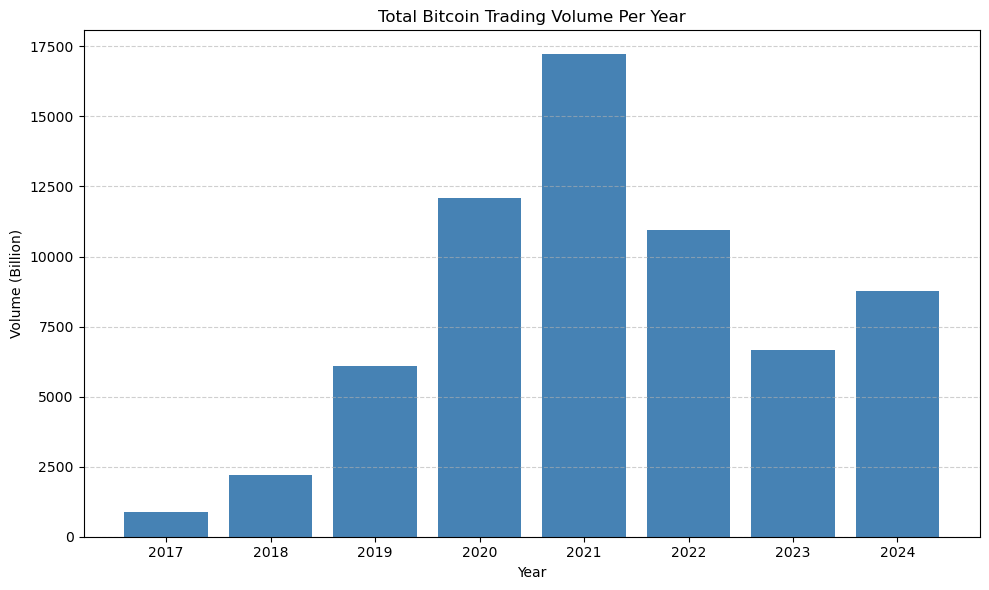

In [15]:
def bargraph(df):

    # group by year
    volume_per_year = df['Volume'].resample('Y').sum()

    # convery index into year
    volume_per_year.index = volume_per_year.index.year
    volume_per_year_billion = volume_per_year / 1e9       # put in billions

    # Plot bar graph
    plt.figure(figsize=(10,6))
    plt.bar(volume_per_year_billion.index, volume_per_year_billion.values, color='steelblue')
    plt.title('Total Bitcoin Trading Volume Per Year')
    plt.xlabel('Year')
    plt.ylabel('Volume (Billion)')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.xticks(volume_per_year_billion.index)
    plt.tight_layout()
    plt.show()
    
bargraph(data)

This bar graph shows the total annual Bitcoin trading volume (in billions) from 2017 through 2024.  We see a steady rise in volume peaking in 2021, driven by institutional adoption and all-time-high price surges, followed by a decline during 2022–2023 due to tightening macroeconomic conditions and crypto-specific setbacks.  Volume begins to rebound slightly in 2024, suggesting renewed market participation.